In [1]:
from lattice.ensemble import Ensemble
from lattice.protein_config import ProteinConfig
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

proteins = ['HHHHHHHHHH', 'HPHPPHPPHH', 'HPPHPPHPHH', 'PPPPPPHPPH', 'PPPPPHHHHH', 'PPPPPPPPPP']
ensembles = [Ensemble(protein) for protein in proteins]

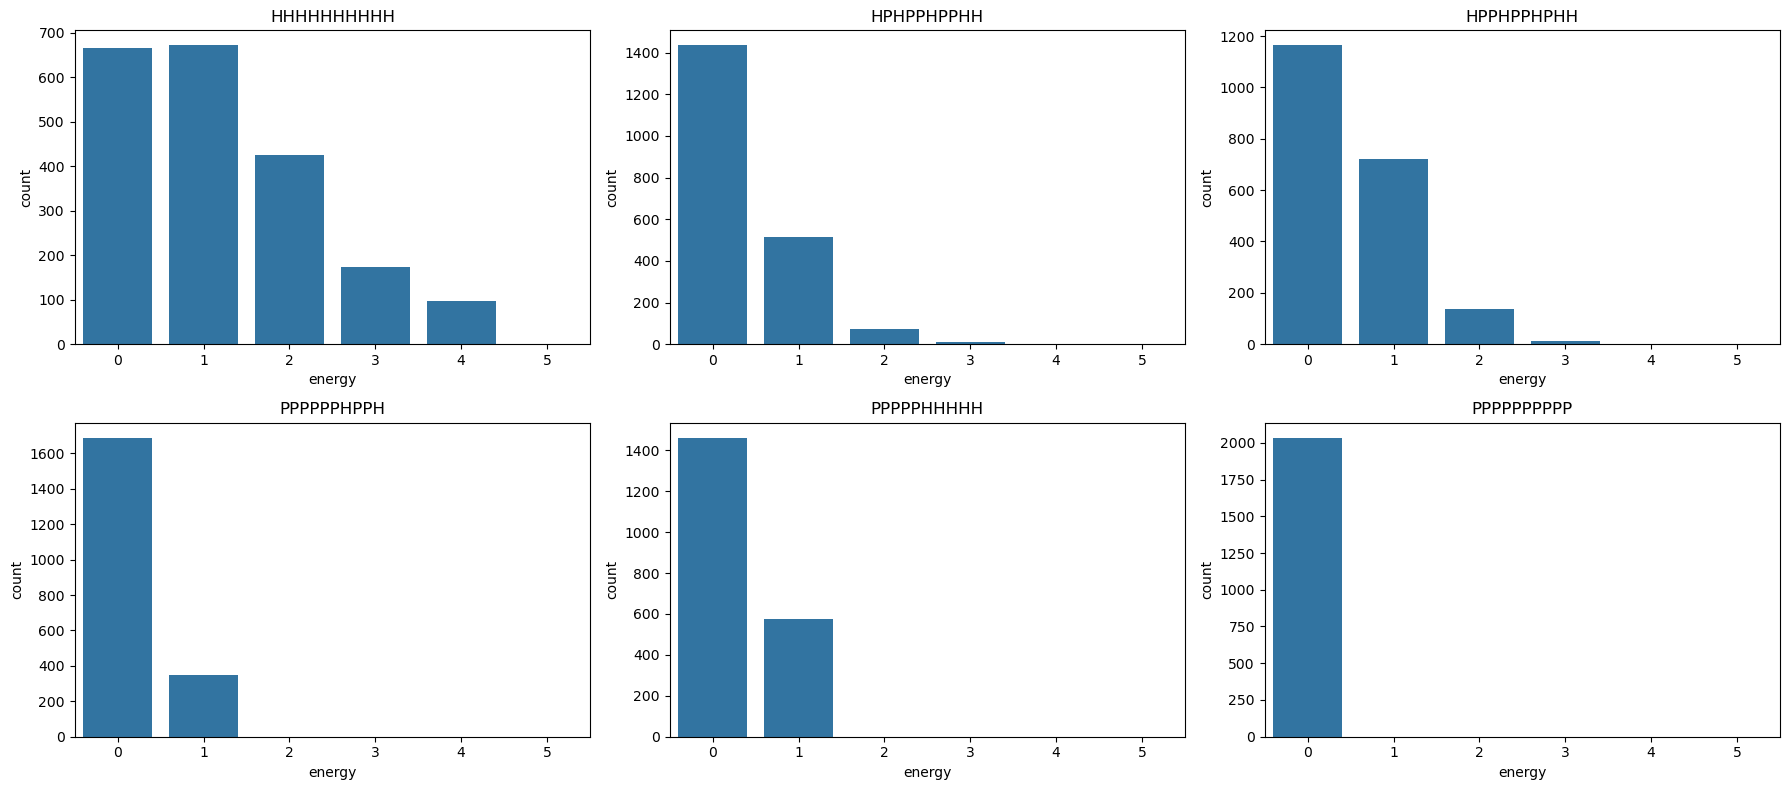

In [2]:
n = len(ensembles)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()

for ax, ens in zip(axes, ensembles):
    sns.barplot(data=ens.degeneracies_df, x="count", y="energy", ax=ax)
    ax.set_title(ens.protein_string)
    ax.set_xlabel("energy")
    ax.set_ylabel("count")
    
plt.tight_layout()
plt.show()

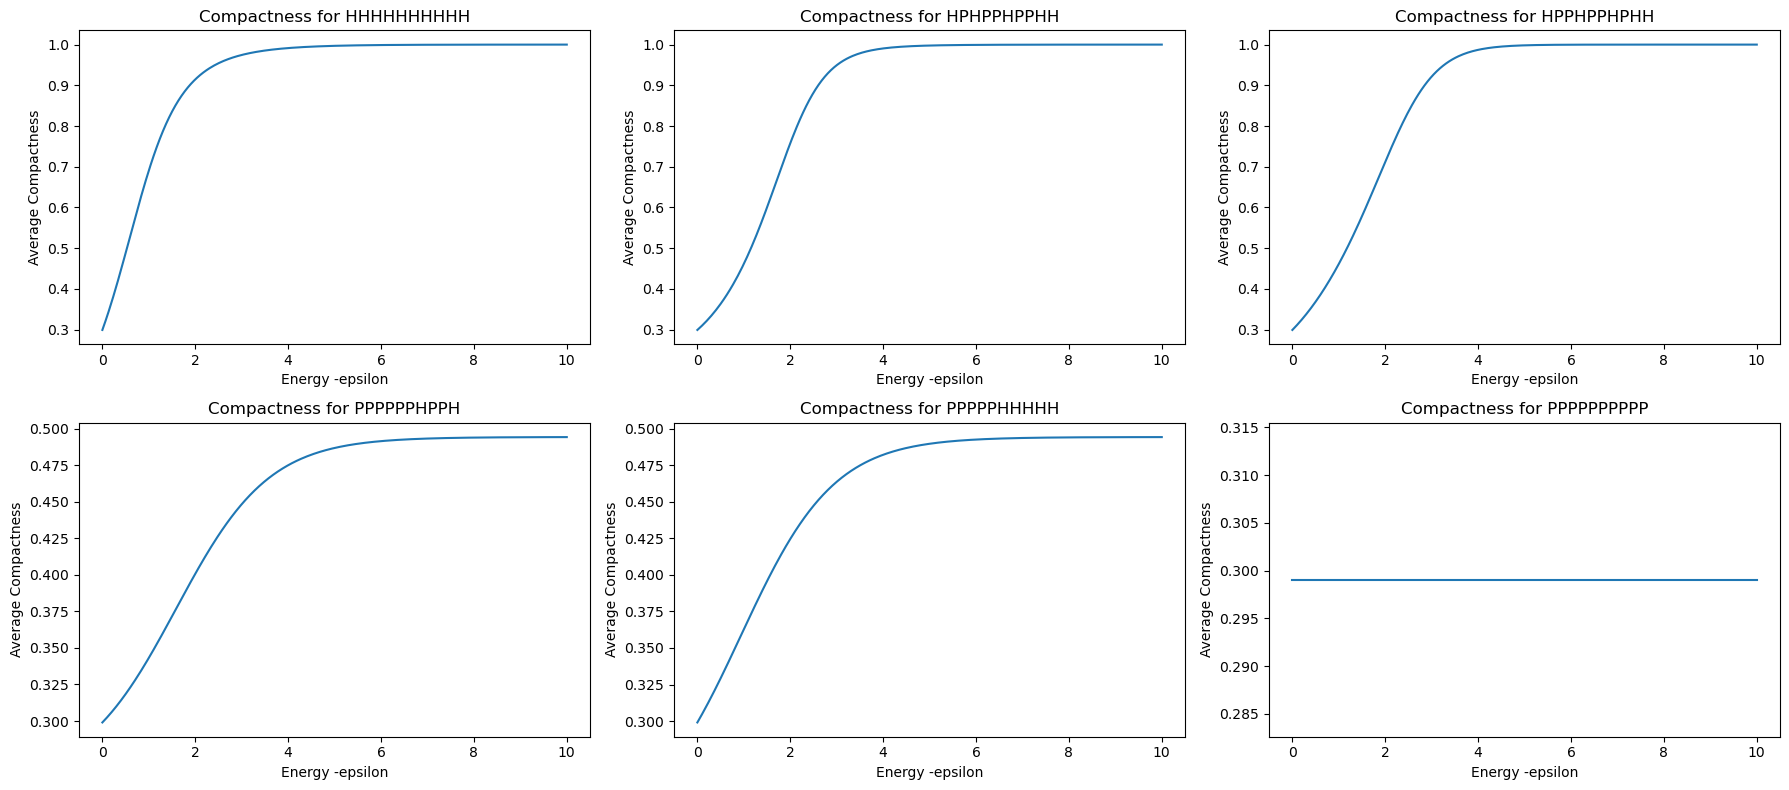

In [3]:
n = len(ensembles)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axes = axes.flatten()

for ax, ens in zip(axes, ensembles):
    L = len(ens.protein_string)
    xs = np.linspace(0, L, 300)

    # if you really mean -x, keep it; otherwise use x
    ys = [ens.p_average_compactness(-x) for x in xs]

    ax.plot(xs, ys)
    ax.set_xlabel("Energy -epsilon")
    ax.set_ylabel("Average Compactness")
    ax.set_title(f"Compactness for {ens.protein_string}")

plt.tight_layout()
plt.show()

In [4]:
ensembles[0].p_average_compactness_native_state

0.9999999999999999